In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl

/data/users/dbruciaf/.conda/envs/pyogcm/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
domf_0 = '/data/users/dbruciaf/AGRIF-NAtl/gs/orca12/domain_cfg.nc'
domf_1 = '/data/users/dbruciaf/AGRIF-NAtl/gs/orca12/1_domain_cfg.nc'
Ugrd_0 = '/scratch/dbruciaf/AGRIF/gs_orca12/u-dd748/nemo_dd748o_1m_20060101-20060201_grid-U.nc'
Vgrd_0 = '/scratch/dbruciaf/AGRIF/gs_orca12/u-dd748/nemo_dd748o_1m_20060101-20060201_grid-V.nc'
Ugrd_1 = '/scratch/dbruciaf/AGRIF/gs_orca12/u-dd748/nemo_1-gs-orca12o_1m_20060101-20060201_grid-U.nc'
Vgrd_1 = '/scratch/dbruciaf/AGRIF/gs_orca12/u-dd748/nemo_1-gs-orca12o_1m_20060101-20060201_grid-V.nc'

In [3]:
ds_d0 = xr.open_dataset(domf_0)
ds_d1 = xr.open_dataset(domf_1)
nav_lon0 = ds_d0.nav_lon
nav_lat0 = ds_d0.nav_lat
nav_lon1 = ds_d1.nav_lon
nav_lat1 = ds_d1.nav_lat

ds_U0 = xr.open_dataset(Ugrd_0).rename_dims({'depthu':'z'}).squeeze()
ds_V0 = xr.open_dataset(Vgrd_0).rename_dims({'depthv':'z'}).squeeze()
ds_U1 = xr.open_dataset(Ugrd_1, chunks={}).rename_dims({'depthu':'z'}).squeeze()
ds_V1 = xr.open_dataset(Vgrd_1, chunks={}).rename_dims({'depthv':'z'}).squeeze()

ds_U0 = ds_U0.assign_coords(nav_lon=nav_lon0, nav_lat=nav_lat0)
ds_V0 = ds_V0.assign_coords(nav_lon=nav_lon0, nav_lat=nav_lat0)
ds_U1 = ds_U1.assign_coords(nav_lon=nav_lon1, nav_lat=nav_lat1)
ds_V1 = ds_V1.assign_coords(nav_lon=nav_lon1, nav_lat=nav_lat1)

ds_U0.coords["x"] = range(ds_U0.dims["x"])
ds_U0.coords["y"] = range(ds_U0.dims["y"])
ds_V0.coords["x"] = range(ds_V0.dims["x"])
ds_V0.coords["y"] = range(ds_V0.dims["y"])
ds_U1.coords["x"] = range(ds_U1.dims["x"])
ds_U1.coords["y"] = range(ds_U1.dims["y"])
ds_V1.coords["x"] = range(ds_V1.dims["x"])
ds_V1.coords["y"] = range(ds_V1.dims["y"])

In [4]:
u0 = ds_U0['uo'].squeeze()
v0 = ds_V0['vo'].squeeze()
# interpolating from U,V to T and calc speed
U0 = u0.rolling({'x':2}).mean().fillna(0.)
V0 = v0.rolling({'y':2}).mean().fillna(0.)
spd0 = np.sqrt(np.power(U0,2) + np.power(V0,2))
spd0 = spd0.where(spd0>0)

In [5]:
# Get rid of discontinuity on lon grid 
#(from https://gist.github.com/willirath/fbfd21f90d7f2a466a9e47041a0cee64)
# see also https://docs.xarray.dev/en/stable/examples/multidimensional-coords.html
after_discont = ~(spd0.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)
spd0.coords["nav_lon"] = (
    spd0.coords["nav_lon"]
    + 360 * after_discont
)

spd0 = spd0.isel(x=slice(1, -1), y=slice(None, -1))
# Marking the boundary of AGRIF domain on the parent model - read from the AGRIF_FixedGrids,in file
spd0[:,779:910,815:816] = np.nan
spd0[:,779:910,1080:1081] = np.nan
spd0[:,779:780,815:1080] = np.nan
spd0[:,910:911,815:1080] = np.nan

spd0 = spd0.isel({'x':slice(700,1120), 'y':slice(750,1020)})

In [6]:
u1 = ds_U1['uo'].squeeze()
v1 = ds_V1['vo'].squeeze()
# interpolating from U,V to T and calc speed
U1 = u1.rolling({'x':2}).mean().fillna(0.)
V1 = v1.rolling({'y':2}).mean().fillna(0.)
spd1 = np.sqrt(np.power(U1,2) + np.power(V1,2))
spd1 = spd1.where(spd1>0)

# Get rid of discontinuity on lon grid 
#(from https://gist.github.com/willirath/fbfd21f90d7f2a466a9e47041a0cee64)
# see also https://docs.xarray.dev/en/stable/examples/multidimensional-coords.html
after_discont = ~(spd1.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)
spd1.coords["nav_lon"] = (
    spd1.coords["nav_lon"]
    + 360 * after_discont
)

spd1 = spd1.isel(x=slice(1, -1), y=slice(None, -1))

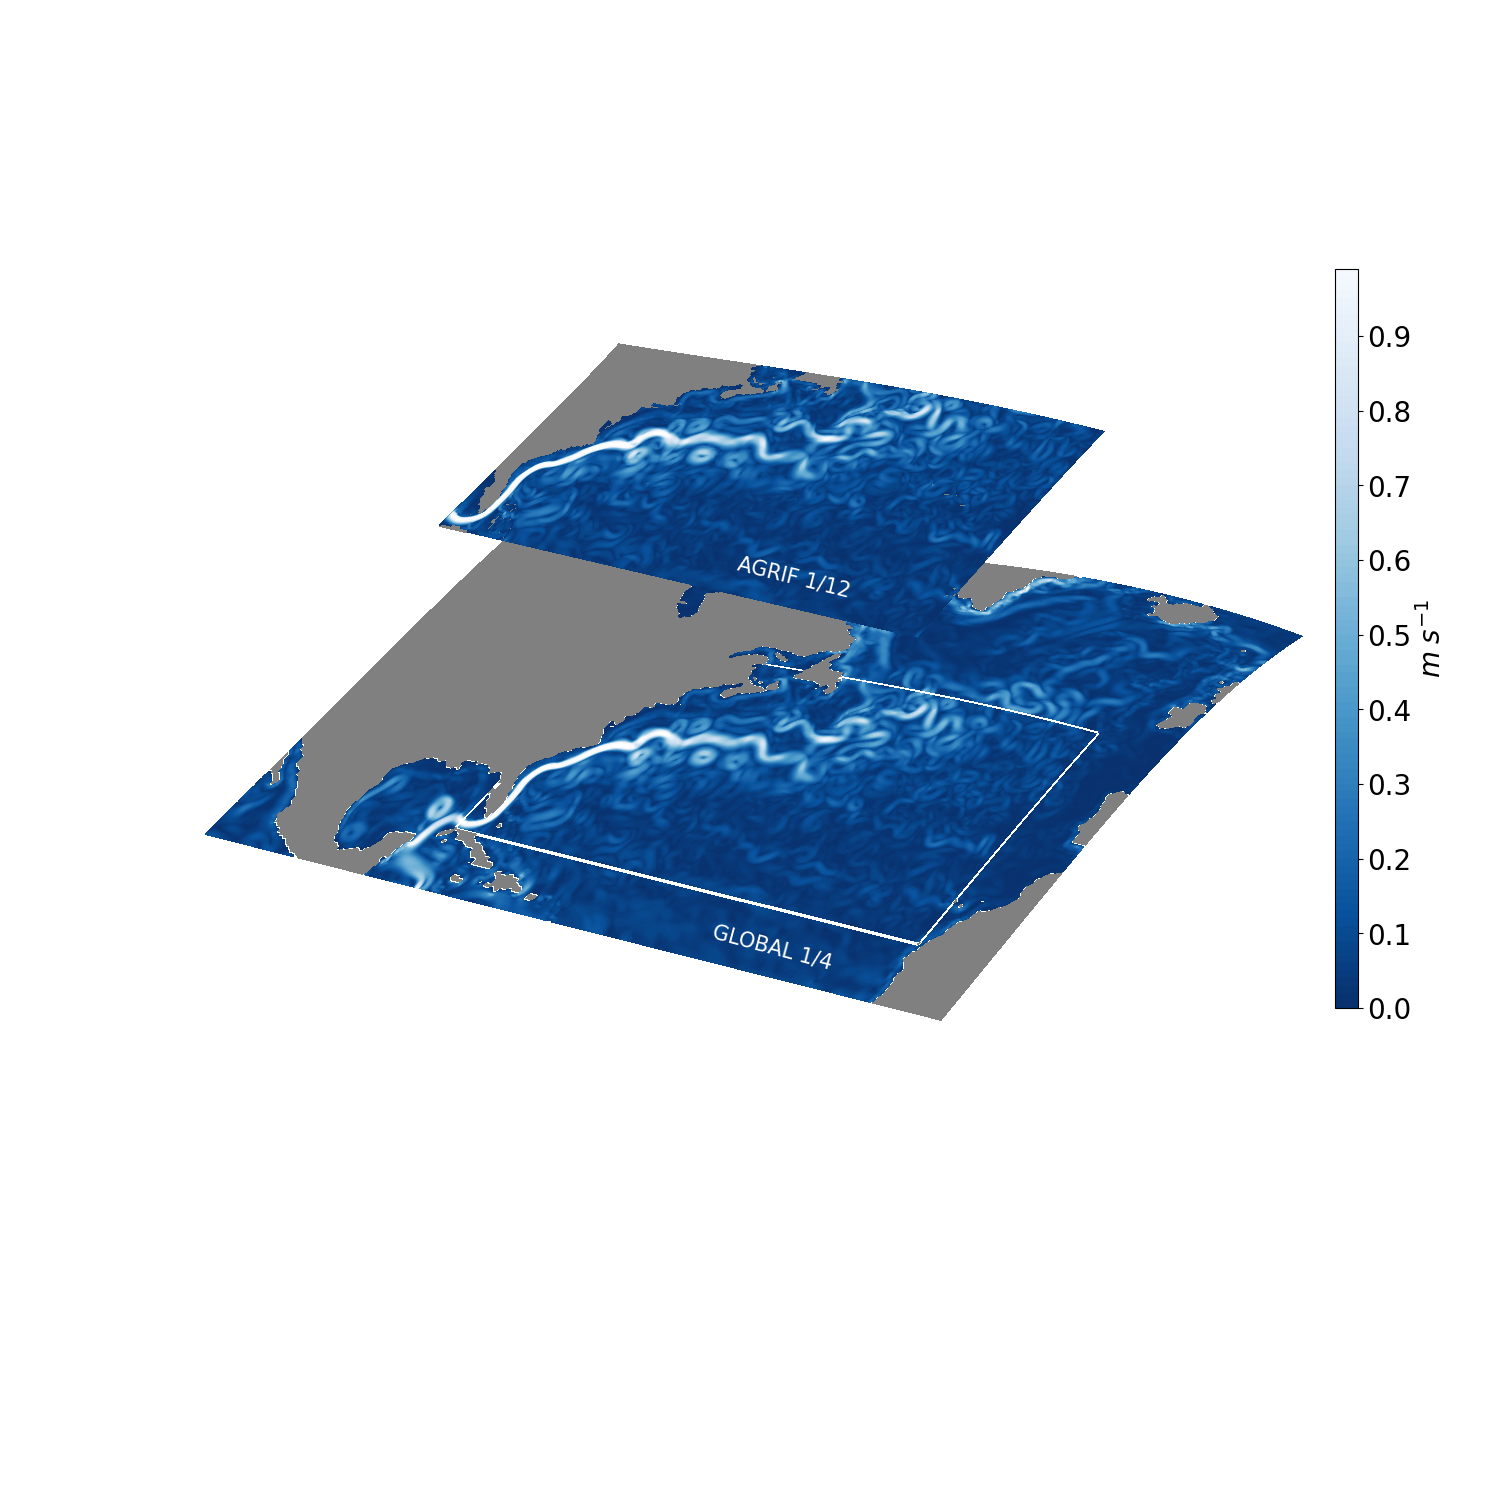

In [7]:
# Model land
land0 = spd0.fillna(-999)
land0 = land0.where(land0==-999)
land1 = spd1.fillna(-999)
land1 = land1.where(land1==-999)

cmap = 'Blues_r'
# figaspect(0.5) makes the figure twice as wide as it is tall. 
# Then the *1.5 increases the size of the figure.
fig = plt.figure(figsize=plt.figaspect(0.5)*4.)
ax = fig.add_subplot((111), projection='3d')

lev = np.arange(0.,1.,0.01)

# AGRIF ZOOM
ax.contourf(land1.nav_lon, land1.nav_lat, land1.isel(z=0),          zdir='z', offset=0., colors='gray')
ax.contourf(spd1.nav_lon, spd1.nav_lat, spd1.isel(z=0), levels=lev, zdir='z', offset=0., cmap=cmap, vmin=0, vmax=1)

# PARENT MODEL
ax.contourf(land0.nav_lon, land0.nav_lat, land0.isel(z=0),                   zdir='z', offset=0.5, colors='gray')
p = ax.contourf(spd0.nav_lon, spd0.nav_lat, spd0.isel(z=0), levels=lev, zdir='z', offset=0.5, cmap=cmap, vmin=0, vmax=1)

plt.gca().invert_zaxis()
ax.set_zlim(1, 0)
ax.set_axis_off()

cax = fig.add_axes([ax.get_position().x1-0.04,ax.get_position().y0+0.25,0.006,ax.get_position().height/2])
cbar = plt.colorbar(p, cax=cax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label='$m\;s^{-1}$',size=20,weight='bold')

ax.text(298, 42, 0.3, "AGRIF 1/12", color='w', size='15', zdir=(1,-0.01,0.), zorder=301)
ax.text(315, 22, 0.61, "GLOBAL 1/4", color='w', size='15', zdir=(1,-0.01,0), zorder=301)

#print('ax.azim {}'.format(ax.azim))
#print('ax.elev {}'.format(ax.elev))
ax.view_init(elev=31, azim=-65)

In [8]:
# AVISO geostrophic currents
aviso = '/data/users/dbruciaf/GS/ssh_aviso/sla_cmems/monthly/dt_global_allsat_phy_l4_200601.nc'
ds_avi = xr.open_dataset(aviso)
ds_avi = ds_avi.rename_dims({'latitude':'y','longitude':'x'})
#ds_avi = ds_avi.assign_coords(x=range(ds_avi.dims["x"]), y=range(ds_avi.dims["y"]))
#ds_avi.coords["y"] = range(ds_avi.dims["y"])
#ds_avi#.dims["x"]
avi_u = ds_avi['ugos'].squeeze()
avi_v = ds_avi['vgos'].squeeze()

avi_u = avi_u.isel({'x':slice(290,690),'y':slice(420,625)})
avi_v = avi_v.isel({'x':slice(290,690),'y':slice(420,625)})

# interpolating from U,V to T and calc speed
U = avi_u.rolling({'x':2}).mean().fillna(0.)
V = avi_v.rolling({'y':2}).mean().fillna(0.)
speed = np.sqrt(np.power(U,2) + np.power(V,2))
speed = speed.where(speed>0)
speed['longitude'] = speed.longitude + 360.

In [9]:
# GOSI10p0 surface current
Ugrd = '/scratch/dbruciaf/AGRIF/gs_orca12/u-dd982/nemo_dd982o_1m_20060101-20060201_grid-U.nc'
Vgrd = '/scratch/dbruciaf/AGRIF/gs_orca12/u-dd982/nemo_dd982o_1m_20060101-20060201_grid-V.nc'
ds_U = xr.open_dataset(Ugrd).rename_dims({'depthu':'z'}).squeeze()
ds_V = xr.open_dataset(Vgrd).rename_dims({'depthv':'z'}).squeeze()
ds_U = ds_U.assign_coords(nav_lon=nav_lon0, nav_lat=nav_lat0)
ds_V = ds_V.assign_coords(nav_lon=nav_lon0, nav_lat=nav_lat0)
ds_U.coords["x"] = range(ds_U.dims["x"])
ds_U.coords["y"] = range(ds_U.dims["y"])
ds_V.coords["x"] = range(ds_V.dims["x"])
ds_V.coords["y"] = range(ds_V.dims["y"])

u = ds_U['uo'].squeeze()
v = ds_V['vo'].squeeze()
# interpolating from U,V to T and calc speed
U = u.rolling({'x':2}).mean().fillna(0.)
V = v.rolling({'y':2}).mean().fillna(0.)
spd = np.sqrt(np.power(U,2) + np.power(V,2))
spd = spd.where(spd>0)

# Get rid of discontinuity on lon grid 
#(from https://gist.github.com/willirath/fbfd21f90d7f2a466a9e47041a0cee64)
# see also https://docs.xarray.dev/en/stable/examples/multidimensional-coords.html
after_discont = ~(spd.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)
spd.coords["nav_lon"] = (
    spd.coords["nav_lon"]
    + 360 * after_discont
)

spd = spd.isel(x=slice(1, -1), y=slice(None, -1))
spd = spd.isel({'x':slice(700,1120), 'y':slice(750,1020)})

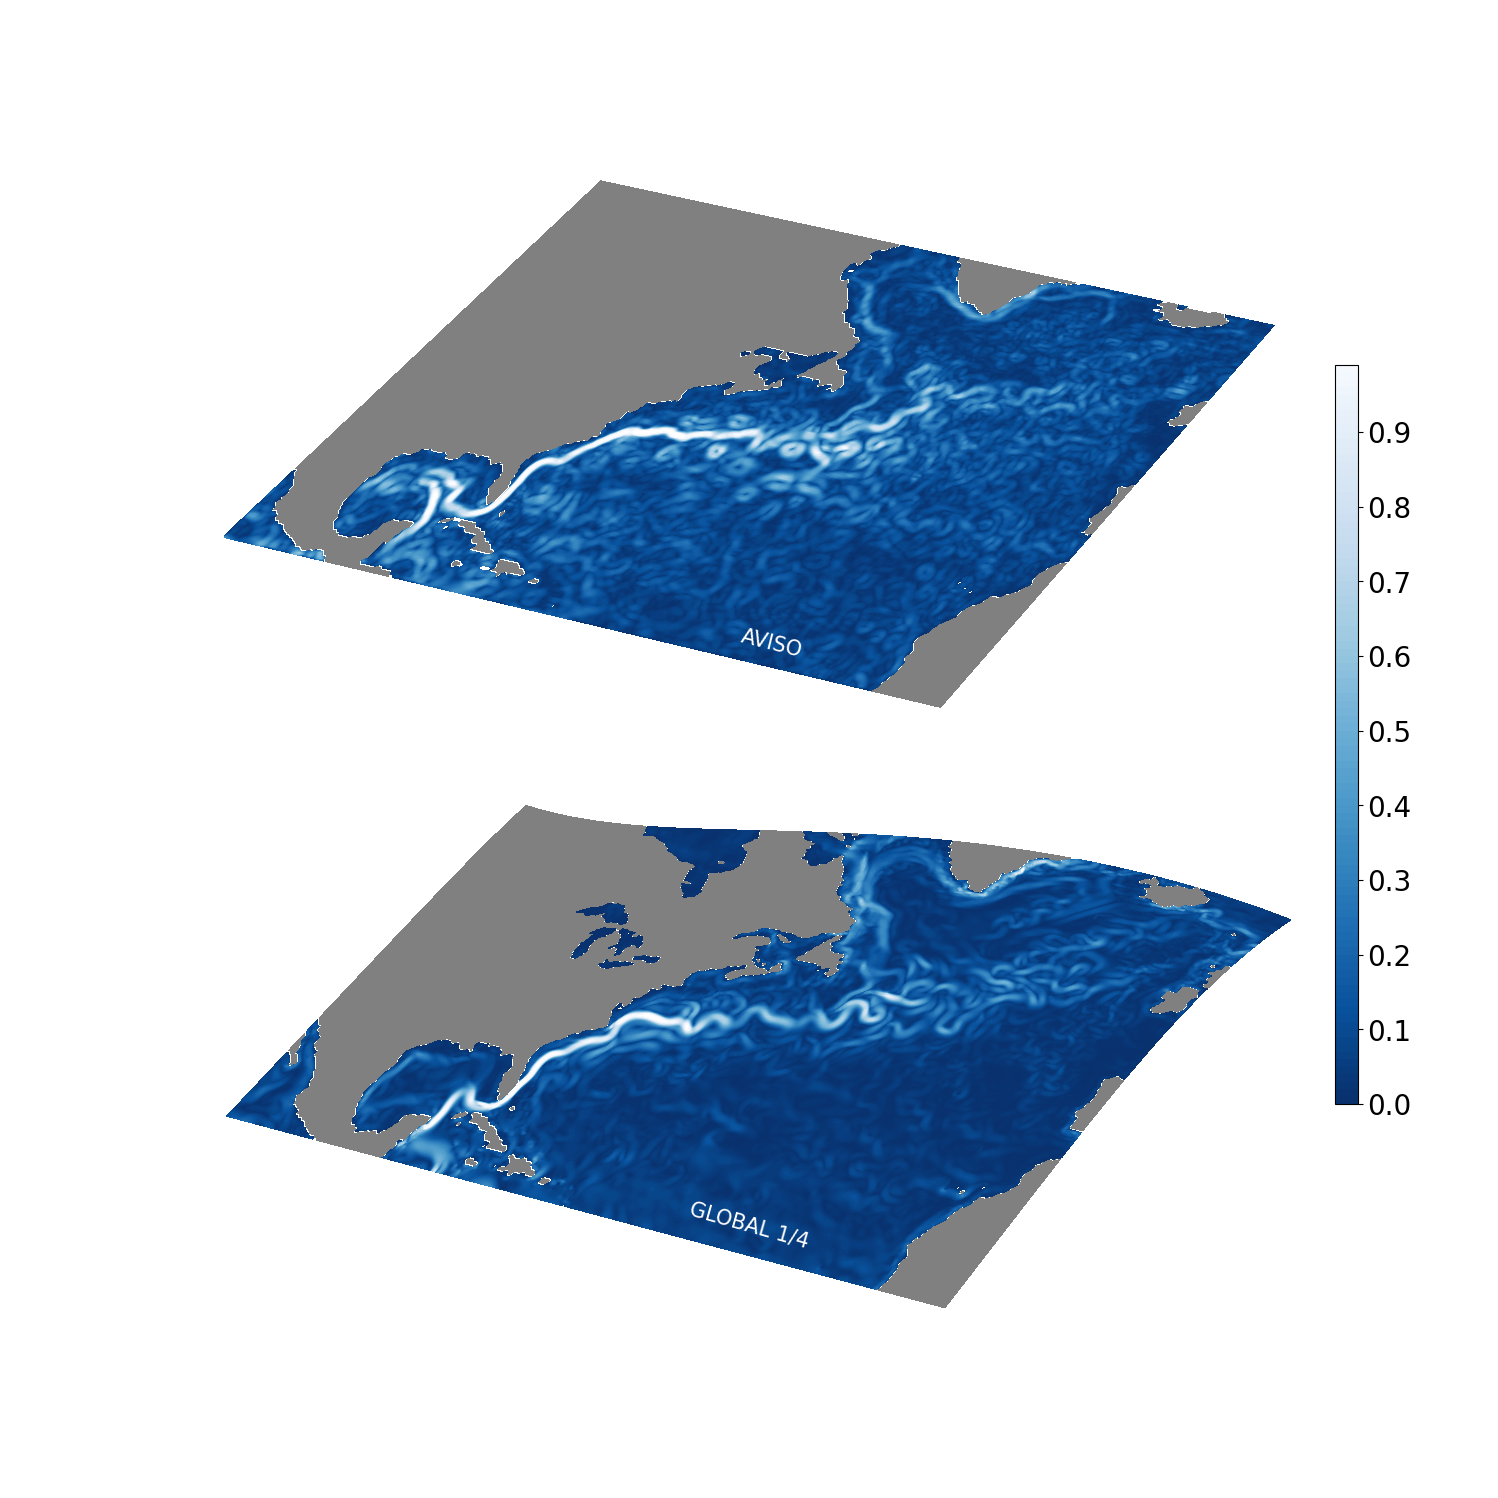

In [10]:
# Model land
landa = speed.fillna(-999)
landa = landa.where(landa==-999)
land = spd.fillna(-999)
land = land.where(land==-999)

cmap = 'Blues_r'
# figaspect(0.5) makes the figure twice as wide as it is tall. 
# Then the *1.5 increases the size of the figure.
fig = plt.figure(figsize=plt.figaspect(0.5)*4.)
ax = fig.add_subplot((111), projection='3d')

lev = np.arange(0.,1.,0.01)

# AVISO 
ax.contourf(landa.longitude, landa.latitude, landa, zdir='z', offset=0., colors='gray')
p = ax.contourf(speed.longitude, speed.latitude, speed, levels=lev, zdir='z', offset=0., cmap=cmap, vmin=0, vmax=1.)

# GOSI10
ax.contourf(land.nav_lon, land.nav_lat, land.isel(z=0), zdir='z', offset=1, colors='gray')
ax.contourf(spd.nav_lon, spd.nav_lat, spd.isel(z=0), levels=lev, zdir='z', offset=1, cmap=cmap, vmin=0, vmax=1.)

plt.gca().invert_zaxis()
ax.set_zlim(1, 0)
ax.set_axis_off()

cax = fig.add_axes([ax.get_position().x1-0.04,ax.get_position().y0+0.2,0.006,ax.get_position().height/2])
cbar = plt.colorbar(p, cax=cax, extend='max')
cbar.ax.tick_params(labelsize=20)


ax.text(305, 35, 0.3, "AVISO", color='w', size='15', zdir=(1,-0.01,0.), zorder=301)
ax.text(300, 32, 1.3, "GLOBAL 1/4", color='w', size='15', zdir=(1,-0.01,0), zorder=301)

ax.view_init(elev=31, azim=-65)